#Usando GAN para gerar novos digitos

In [53]:
import os
import numpy as np
import matplotlib.pyplot as plt
#from tqdm import tqdm

import matplotlib
import tensorflow as tf

from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout
from keras.layers import LeakyReLU
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import initializers

In [ ]:
os.environ["KERAS_BACKEND"] = "tensorflow"

np.random.seed(42)
random_dim = 100

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5)/127.5  
X_train = X_train.reshape(60000, 784)

In [ ]:
otimizador = Adam(lr=0.0002, beta_1=0.5)

In [ ]:
gerador = Sequential()
gerador.add(Dense(256, input_dim=random_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
gerador.add(LeakyReLU(0.2))

gerador.add(Dense(512))
gerador.add(LeakyReLU(0.2))

gerador.add(Dense(1024))
gerador.add(LeakyReLU(0.2))

gerador.add(Dense(784, activation='tanh'))
gerador.compile(loss='binary_crossentropy', optimizer=otimizador)

In [ ]:
discriminador = Sequential()
discriminador.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminador.add(LeakyReLU(0.2))
discriminador.add(Dropout(0.3))

discriminador.add(Dense(512))
discriminador.add(LeakyReLU(0.2))
discriminador.add(Dropout(0.3))

discriminador.add(Dense(256))
discriminador.add(LeakyReLU(0.2))
discriminador.add(Dropout(0.3))

discriminador.add(Dense(1, activation='sigmoid'))
discriminador.compile(loss='binary_crossentropy', optimizer=otimizador)

In [ ]:
def gerar_gan(discriminador, randomDim, gerador, otimizador):
  discriminador.trainable = False
  gan_input = Input(shape=(random_dim,))
  x = gerador(gan_input)

  gan_output = discriminador(x)
  gan = Model(inputs=gan_input, outputs=gan_output)
  gan.compile(loss='binary_crossentropy', optimizer=otimizador)

  return gan

In [ ]:
def salvar_digito_gerado(epoca, exemplos=25, dim=(5, 5), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[exemplos, random_dim])
    imagem_gerada = gerador.predict(noise)
    imagem_gerada = imagem_gerada.reshape(exemplos, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(imagem_gerada.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(imagem_gerada[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_digito_gerado_epoca_%d.png' % epoca)

In [ ]:
epochs = 800
batchSize = 128

gLosses = []
dLosses = []

batch_count = X_train.shape[0] / batchSize

generator = gerador
gan = gerar_gan(discriminador, random_dim, gerador, otimizador)

batchCount = X_train.shape[0] / batchSize
print('Épocas:', epochs)
print('Batch size:', batchSize)
print('Batches por época:', batchCount)

for e in range(1, epochs+1):
    print('-'*15, 'Época %d' % e, '-'*15)

    noise = np.random.normal(0, 1, size=[batchSize, random_dim])
    imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]

    imagemGerada = gerador.predict(noise)
    X = np.concatenate([imageBatch, imagemGerada])

    yDis = np.zeros(2*batchSize)
    yDis[:batchSize] = 0.9

    discriminador.trainable = True
    dloss = discriminador.train_on_batch(X, yDis)

    yGen = np.ones(batchSize)
    discriminador.trainable = False
    gloss = gan.train_on_batch(noise, yGen)

    gLosses.append(gloss)
    dLosses.append(dloss)

    salvar_digito_gerado(e)

In [ ]:
gerador.save('GAN_gerador_MNIST.h5')
discriminador.save('GAN_discriminador_MNIST.h5')

## Carregar o Gerador e criar um novo dígito

In [1]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [2]:
z_dim = 100

g = keras.models.load_model('/content/gerador.h5')
g.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               25856     
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 dense_2 (Dense)             (None, 1024)              525312    
                                                                 
 dense_3 (Dense)             (None, 784)               803600    
                                                                 
Total params: 1,486,352
Trainable params: 1,486,352
Non-trainable params: 0
_________________________________________________________________


In [45]:
def gerar_digito(n_ex=10, dim=(1, 10), figsize=(2, 2)):
    noise = np.random.normal(0, 1, size=(n_ex, z_dim))
    generated_images = g.predict(noise)
    generated_images = generated_images.reshape(28, 28)
    
    plt.figure(figsize=figsize)
    plt.imshow(generated_images, interpolation='nearest', cmap=matplotlib.cm.binary)
    plt.subplot()    
    plt.tight_layout()
    plt.axis('off')
    plt.savefig("digito_gerado.png")

    plt.show()      


1/1 [==============================] - 0s 23ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


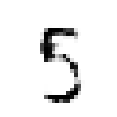

In [47]:
gerar_digito(n_ex=1)

## Transformar a imagem em um array de pixels

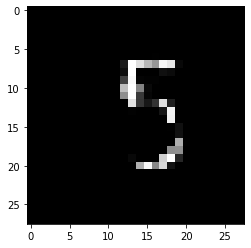

28
[[255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255.
  255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255.]
 [255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255.
  255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255.]
 [255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255.
  255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255.]
 [255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255.
  255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255.]
 [255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255.
  255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255.]
 [255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255.
  255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255.]
 [255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255.
  254. 255. 253. 255. 254. 255. 255. 255. 255. 255. 255

In [62]:
image_list = '/content/digito_gerado.png'
array_list = np.squeeze( tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(image_list, color_mode='grayscale', target_size=(28,28))))

plt.imshow(array_list, cmap=matplotlib.cm.binary)
plt.show()

print(len(array_list))
print(array_list)
print(array_list.shape)
